In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import os 
import pathlib

import warnings 
warnings.simplefilter('ignore')
print(f'TensorFlow Version: {tf.__version__}')

TensorFlow Version: 2.8.2


In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   148M      0  0:00:05  0:00:05 --:--:--  147M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [ ]:
!ls PetImages

Cat  Dog


In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [ ]:
class_names = train_ds.class_names

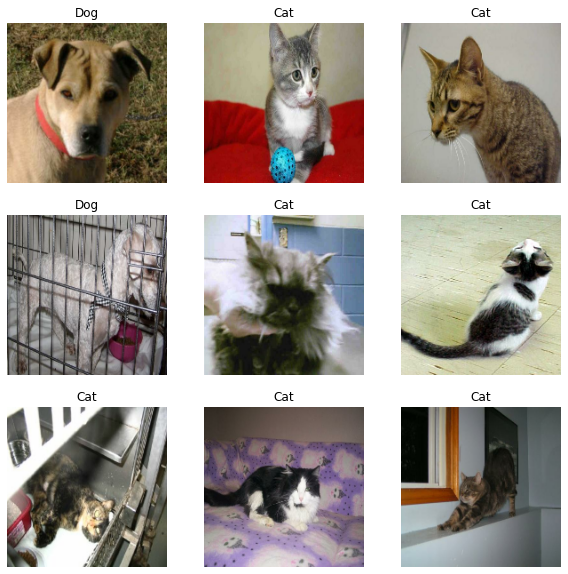

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(10):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
def build_plot(history):
    epochs = np.arange(len(history.epoch))
    accuracy = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.figure(figsize=(15,7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'r', label = "Accuracy")
    plt.plot(epochs, val_acc, 'bo--', label = "Validation Accuracy")
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid("on")
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label = "Loss")
    plt.plot(epochs, val_loss, 'bo--', label = "Validation Loss")
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.legend()
    plt.grid("on")
    plt.show()

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_hist = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs = 30
)

Epoch 1/30
586/586 [==============================] - 44s 73ms/step - loss: 0.6155 - accuracy: 0.6564 - val_loss: 0.5280 - val_accuracy: 0.7356
Epoch 2/30
586/586 [==============================] - 34s 58ms/step - loss: 0.4698 - accuracy: 0.7732 - val_loss: 0.5059 - val_accuracy: 0.7418
Epoch 3/30
586/586 [==============================] - 33s 56ms/step - loss: 0.3862 - accuracy: 0.8227 - val_loss: 0.4795 - val_accuracy: 0.7819
Epoch 4/30
586/586 [==============================] - 32s 53ms/step - loss: 0.2962 - accuracy: 0.8745 - val_loss: 0.5861 - val_accuracy: 0.7783
Epoch 5/30
586/586 [==============================] - 34s 56ms/step - loss: 0.1928 - accuracy: 0.9224 - val_loss: 0.6507 - val_accuracy: 0.7999
Epoch 6/30
586/586 [==============================] - 32s 54ms/step - loss: 0.1128 - accuracy: 0.9566 - val_loss: 0.8539 - val_accuracy: 0.7950
Epoch 7/30
586/586 [==============================] - 32s 53ms/step - loss: 0.0741 - accuracy: 0.9734 - val_loss: 0.9398 - val_accuracy:

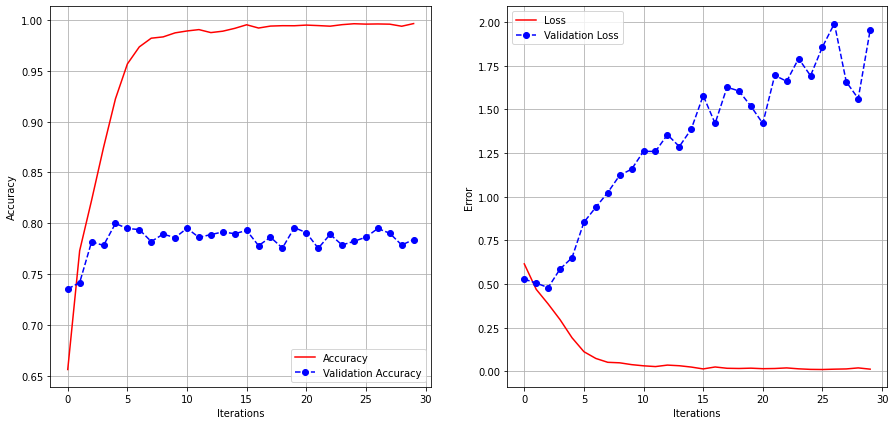

In [ ]:
build_plot(model_hist)

- Here, the overfitting is that validation loss moves away from the training loss. validation loss increases while training loss decreases. (Low bias and High Variance)

**Options to prevent to overfitting:**

1. Cross-validation. Cross-validation is a powerful preventative measure against overfitting. 
2. Train with more data. It won't work every time, but training with more data can help algorithms detect the signal better.
3. Remove features. 
4. Early stopping. 
5. Regularization. 
6. Ensembling.

In [ ]:
model.save_weights('/content/drive/My Drive/Global AI Hub/ResNet50Trained.h5')
np.save('/content/drive/My Drive/Global AI Hub/ResNet50History.npy', model_hist.history)

In [ ]:
import tensorflow_hub as hub
resnet_v2 = 'https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5'

feature_extractor_layer = hub.KerasLayer(
    resnet_v2,
    input_shape=(180, 180, 3),
    trainable=False
)

In [ ]:
resnet = tf.keras.applications.ResNet50(
    include_top = False,
    weights='imagenet',
    input_shape=(180,180,3),
)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
num_classes = len(train_ds.class_names)

resnet_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  resnet,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
resnet_model.build(input_shape=(None,180,180,3))
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 256)               18874624  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 42,462,593
Trainable params: 42,409,473
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
history = resnet_model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs = 10
)

Epoch 1/10
586/586 [==============================] - 180s 275ms/step - loss: 0.6164 - accuracy: 0.7769 - val_loss: 0.7683 - val_accuracy: 0.4957
Epoch 2/10
586/586 [==============================] - 157s 266ms/step - loss: 0.2135 - accuracy: 0.9173 - val_loss: 0.3200 - val_accuracy: 0.8567
Epoch 3/10
586/586 [==============================] - 156s 266ms/step - loss: 0.1344 - accuracy: 0.9479 - val_loss: 0.2114 - val_accuracy: 0.9156
Epoch 4/10
586/586 [==============================] - 157s 267ms/step - loss: 0.1461 - accuracy: 0.9445 - val_loss: 0.2276 - val_accuracy: 0.8981
Epoch 5/10
586/586 [==============================] - 156s 266ms/step - loss: 0.4432 - accuracy: 0.8007 - val_loss: 0.5253 - val_accuracy: 0.7320
Epoch 6/10
586/586 [==============================] - 156s 266ms/step - loss: 0.2751 - accuracy: 0.8803 - val_loss: 0.4154 - val_accuracy: 0.8007
Epoch 7/10
586/586 [==============================] - 156s 266ms/step - loss: 0.1901 - accuracy: 0.9171 - val_loss: 0.3651 -

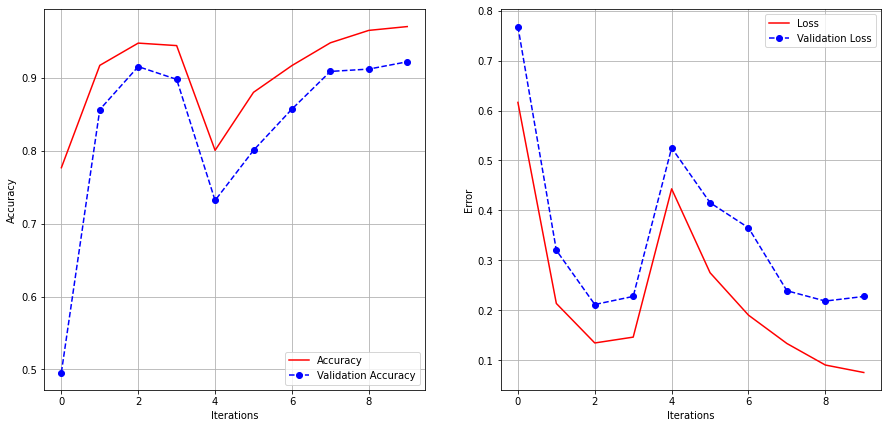

In [ ]:
build_plot(history)

A sudden drop in accuracy while training **looking for reasons of the drop and solutions to fix it**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
resnet_model.save_weights('/content/drive/My Drive/Global AI Hub/ResNet50Trained.h5')
np.save('/content/drive/My Drive/Global AI Hub/ResNet50History.npy', history.history)

In [ ]:
# train_images, train_labels = [], []
# for images, labels in train_ds.as_numpy_iterator():
#     train_images.append(images)
#     train_labels.append(labels)

In [ ]:
# test_images, test_labels = [], []
# for images, labels in val_ds.as_numpy_iterator():
#     test_images.append(images)
#     test_labels.append(labels)

In [ ]:
TRAIN_BUF=1000
BATCH_SIZE=64

# train_dataset = tf.data.Dataset.from_tensor_slices(train_ds).shuffle(TRAIN_BUF).batch(BATCH_SIZE, drop_remainder=True)
# test_dataset = tf.data.Dataset.from_tensor_slices(test_ds).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>